In [1]:
%load_ext autoreload
%autoreload 2

import helper_functions as hf
from imports import *
import importlib

num_available_cpus = multiprocessing.cpu_count()
print("Number of available CPUs:", num_available_cpus)

torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device =", device)
torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')

torch.set_num_threads(num_available_cpus)

print("Number of threads:", torch.get_num_threads())
print("Number of interop threads:", torch.get_num_interop_threads())

Number of available CPUs: 80
Device = cuda:0
Number of threads: 80
Number of interop threads: 80


/nobackup/users/sambt/anaconda3/envs/quak/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

model = "XYY_X3000_Y80_UL17_clip10_NSRATQUAD_k6_hf120_nbpl4_tb10_addMjj.pt"
bkg_model = "QCDBKG_clip10_NSRATQUAD_k6_hf120_nbpl4_tb10_addMjj.pt"
flow = hf.load_model(name=model)
bkg_flow = hf.load_model(name=bkg_model)
bkg_data, bkg_unnorm, bkg_mass = hf.load_full("QCDBKG",num_batches=2,add_mjj=True)
bkg_mean = np.mean(bkg_unnorm,axis=0)
bkg_std = np.std(bkg_unnorm,axis=0)
sig, sig_unnorm, sig_mass = hf.load_full("XYY_X3000_Y80_UL17",bkg_mean=bkg_mean,bkg_std=bkg_std,add_mjj=True)

In [3]:
sig_losses = -flow.eval_log_prob(sig)[0]
bkg_losses = -flow.eval_log_prob(bkg_data)[0]

sig_losses_bkg = -bkg_flow.eval_log_prob(sig)[0]
bkg_losses_bkg = -bkg_flow.eval_log_prob(bkg_data)[0]

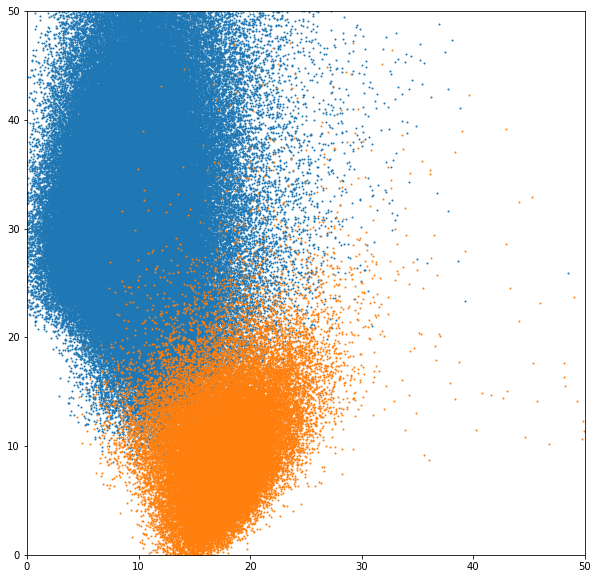

In [4]:
plt.figure(figsize=(10,10))
plt.scatter(bkg_losses_bkg,bkg_losses,s=1)
plt.scatter(sig_losses_bkg,sig_losses,s=1)
plt.xlim([0,50])
plt.ylim([0,50])
plt.savefig("plots/mass_decorrelation/XYY-training/quak-space-noTransform.png")

Sig mass - sigtr sig loss correlation: 0.09260870417699028
Sig mass - bkgtr sig loss correlation: 0.2109966609408989
Bkg mass - sigtr bkg loss correlation: -0.2359897673584698
Bkg mass - bkgtr bkg loss correlation: 0.2338557216080435


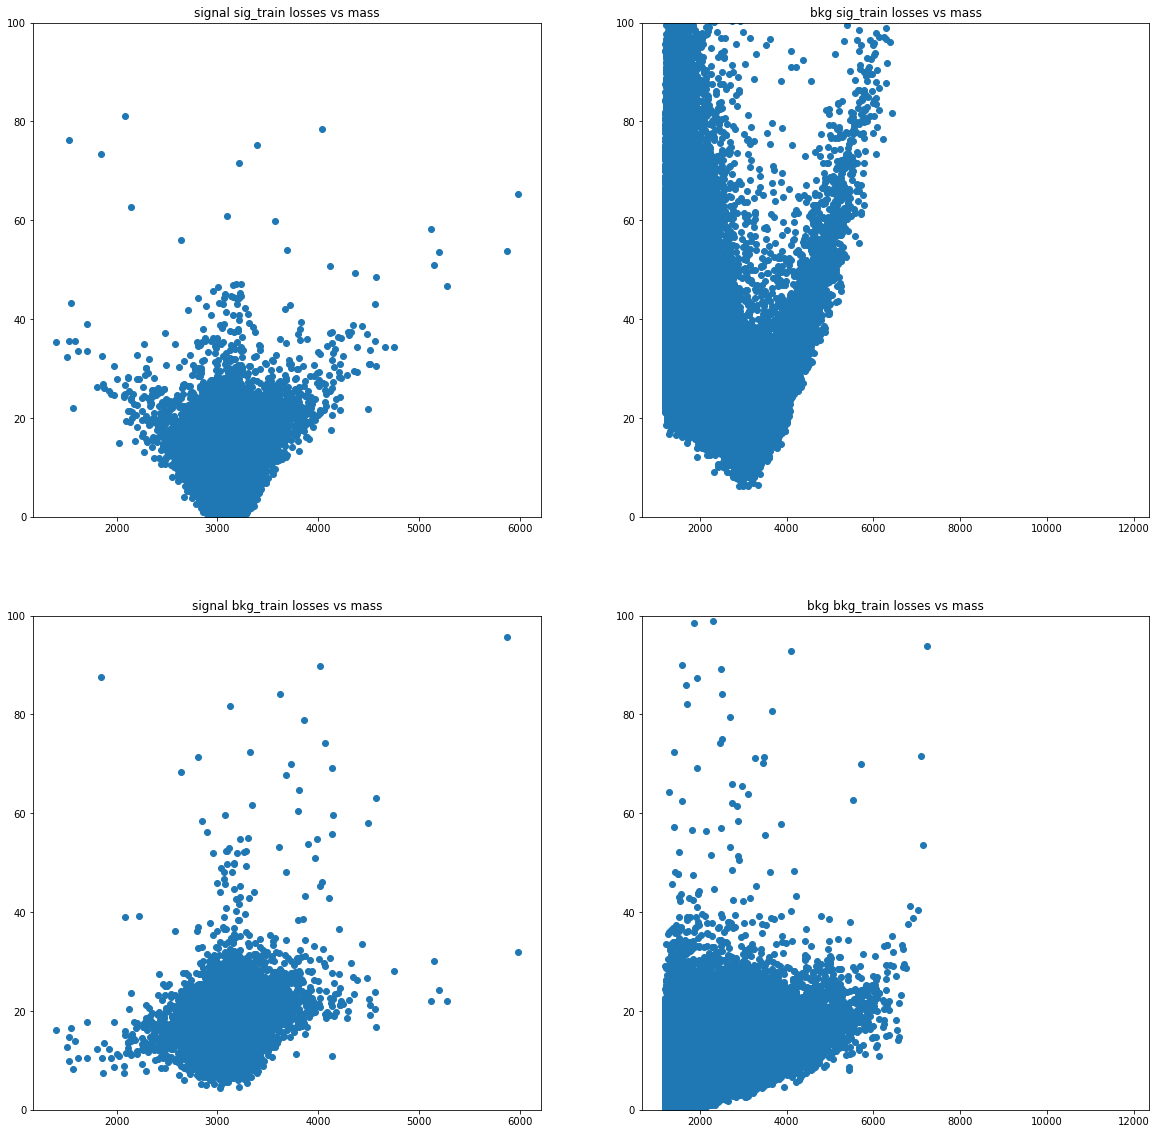

In [5]:
plt.figure(figsize=(20,20))

plt.subplot(221)
plt.scatter(sig_mass,sig_losses)
plt.ylim([0,100])
plt.title("signal sig_train losses vs mass")

plt.subplot(222)
plt.scatter(bkg_mass,bkg_losses)
plt.ylim([0,100])
plt.title("bkg sig_train losses vs mass")

plt.subplot(223)
plt.scatter(sig_mass,sig_losses_bkg)
plt.ylim([0,100])
plt.title("signal bkg_train losses vs mass")

plt.subplot(224)
plt.scatter(bkg_mass,bkg_losses_bkg)
plt.ylim([0,100])
plt.title("bkg bkg_train losses vs mass")

plt.savefig("plots/mass_decorrelation/XYY-training/loss_vs_mass.png")

corr1, p1 = pearsonr(sig_mass[:,0],sig_losses)
corr2, p2 = pearsonr(sig_mass[:,0],sig_losses_bkg)
corr3, p3 = pearsonr(bkg_mass[:,0],bkg_losses)
corr4, p4 = pearsonr(bkg_mass[:,0],bkg_losses_bkg)

print("Sig mass - sigtr sig loss correlation: {0}".format(corr1))
print("Sig mass - bkgtr sig loss correlation: {0}".format(corr2))
print("Bkg mass - sigtr bkg loss correlation: {0}".format(corr3))
print("Bkg mass - bkgtr bkg loss correlation: {0}".format(corr4))

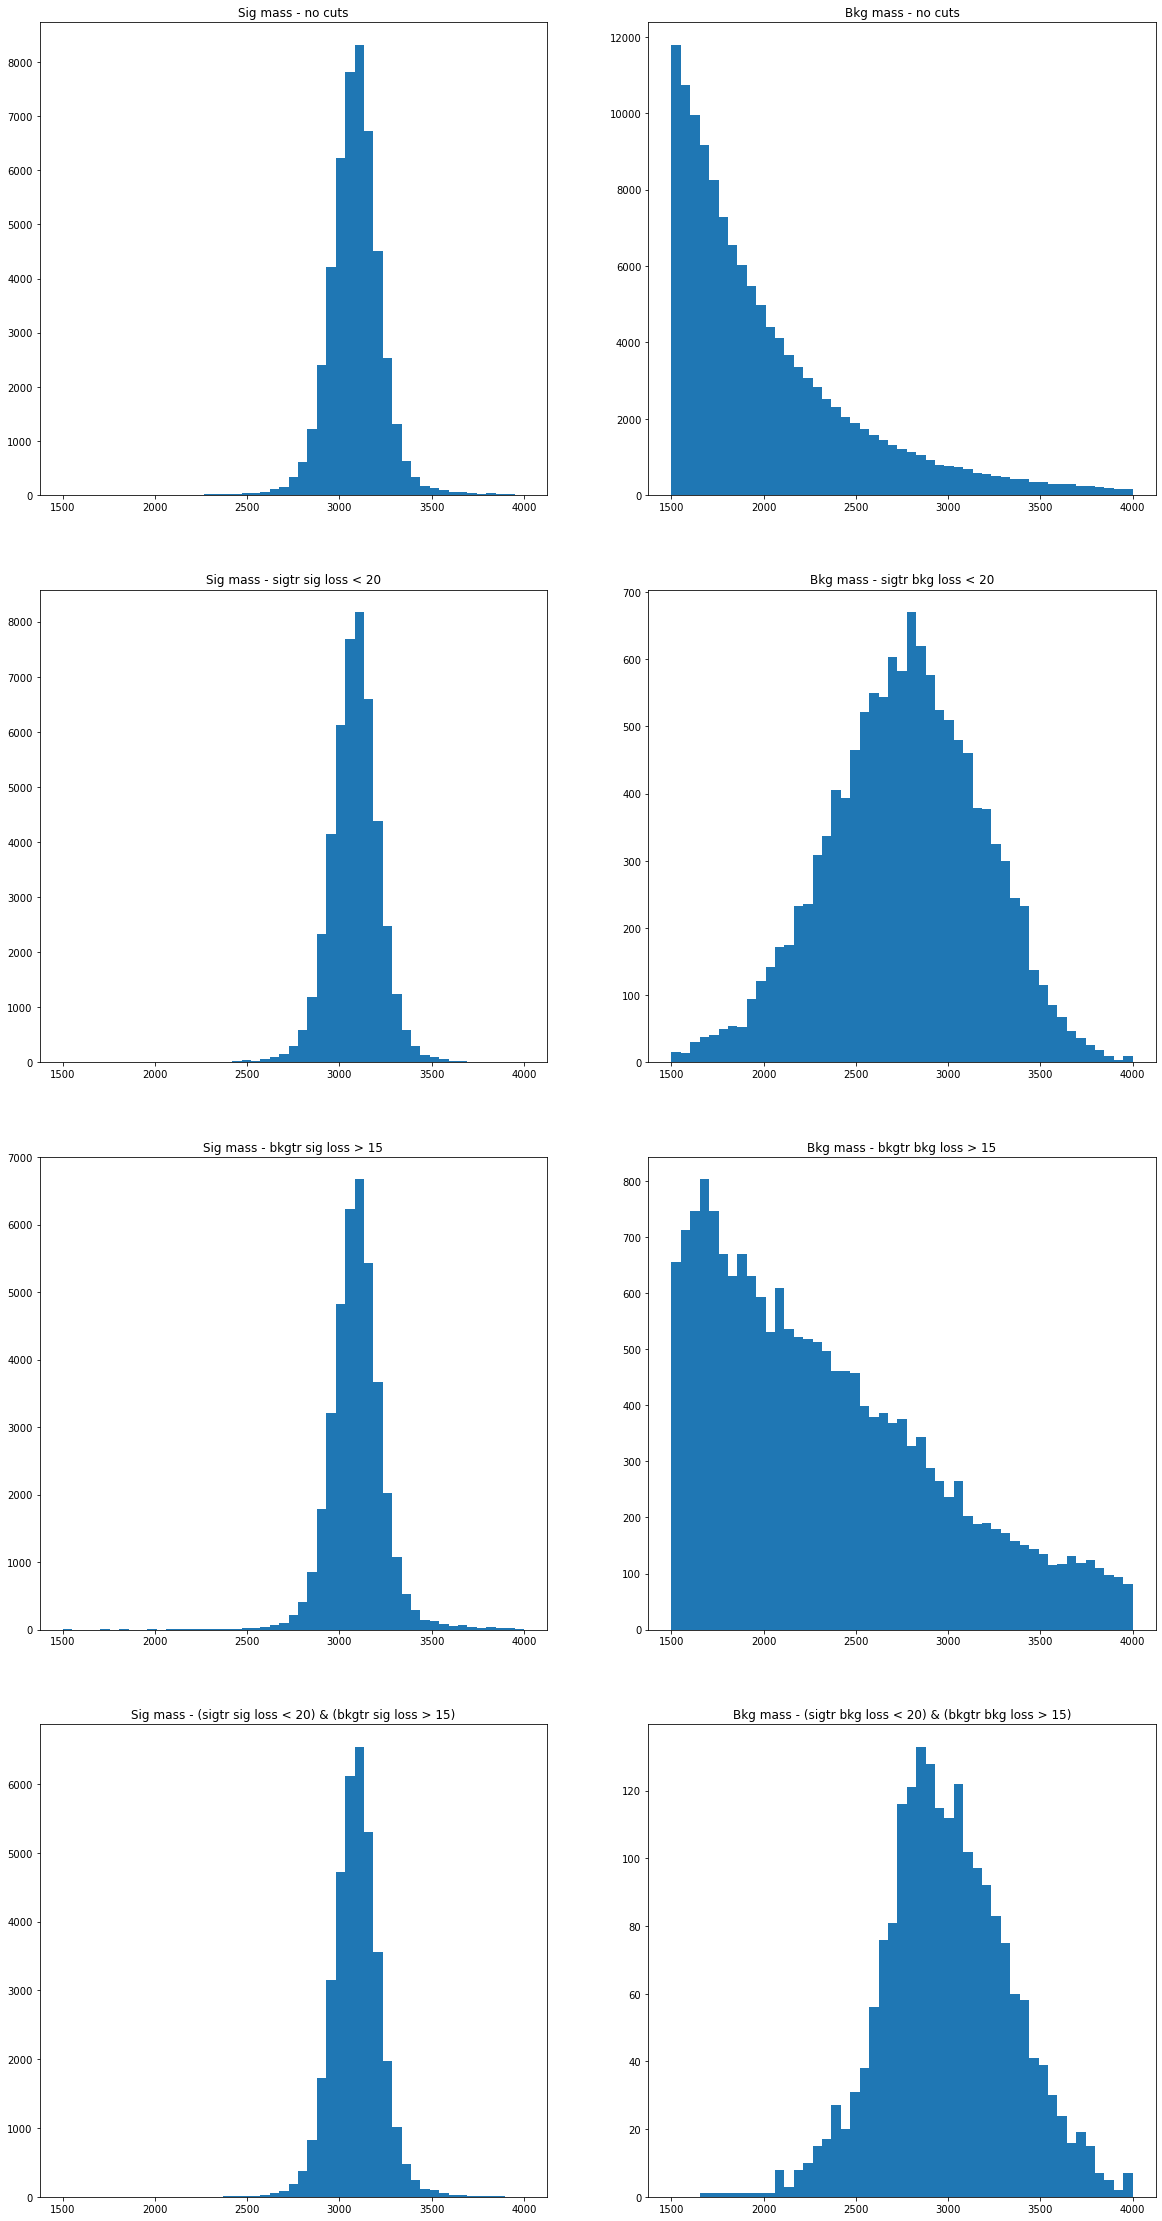

In [6]:
plt.figure(figsize=(20,40))

plt.subplot(421)
h1 = plt.hist(sig_mass,bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - no cuts")

plt.subplot(422)
h2 = plt.hist(bkg_mass,bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - no cuts")

plt.subplot(423)
h1 = plt.hist(sig_mass[(sig_losses<20)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - sigtr sig loss < 20")

plt.subplot(424)
h2 = plt.hist(bkg_mass[(bkg_losses<20)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - sigtr bkg loss < 20")

plt.subplot(425)
h1 = plt.hist(sig_mass[(sig_losses_bkg>15)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - bkgtr sig loss > 15")

plt.subplot(426)
h2 = plt.hist(bkg_mass[(bkg_losses_bkg>15)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - bkgtr bkg loss > 15")

plt.subplot(427)
h1 = plt.hist(sig_mass[(sig_losses<20)&(sig_losses_bkg>15)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - (sigtr sig loss < 20) & (bkgtr sig loss > 15)")

plt.subplot(428)
h2 = plt.hist(bkg_mass[(bkg_losses<20)&(bkg_losses_bkg>15)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - (sigtr bkg loss < 20) & (bkgtr bkg loss > 15)")

plt.savefig("plots/mass_decorrelation/XYY-training/mass-spectra-noTransform.png")

In [22]:
# try to decorrelate
pca = PCA()
nmax = min(bkg_mass.shape[0],sig_mass.shape[0])
alldata = np.concatenate((bkg_mass[:nmax],bkg_losses[:nmax,np.newaxis],bkg_losses_bkg[:nmax,np.newaxis],sig_mass,sig_losses[:nmax,np.newaxis],sig_losses_bkg[:nmax,np.newaxis]),axis=1)
pca = pca.fit(alldata)

In [23]:
transform = pca.transform(alldata[:nmax])

bkg_transform = transform[:,:3]
sig_transform = transform[:,3:]

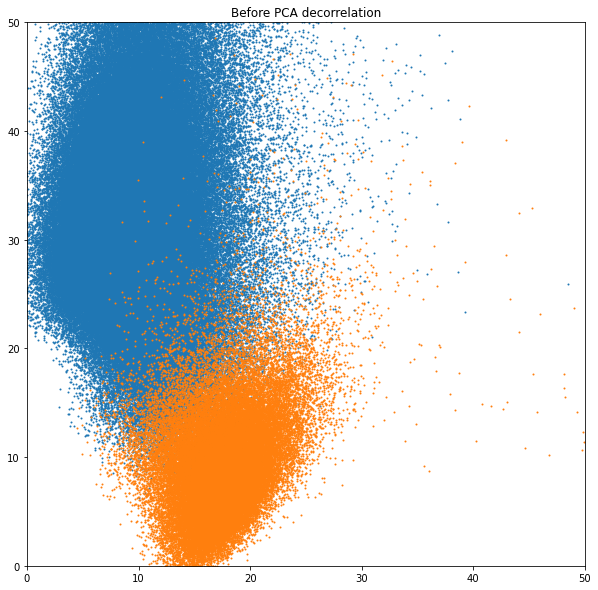

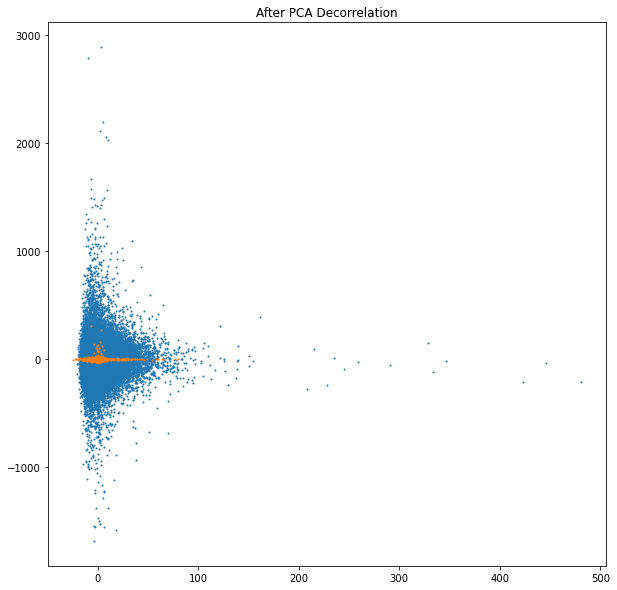

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(bkg_losses_bkg,bkg_losses,s=1)
plt.scatter(sig_losses_bkg,sig_losses,s=1)
plt.xlim([0,50])
plt.ylim([0,50])
plt.title("Before PCA decorrelation")

plt.figure(figsize=(10,10))
plt.scatter(bkg_transform[:,2],bkg_transform[:,1],s=1)
plt.scatter(sig_transform[:,2],sig_transform[:,1],s=1)
#plt.ylim([-20,20])
#plt.xlim([-20,20])
plt.title("After PCA Decorrelation")

plt.savefig("plots/mass_decorrelation/XYY-training/before-after-pca.png")

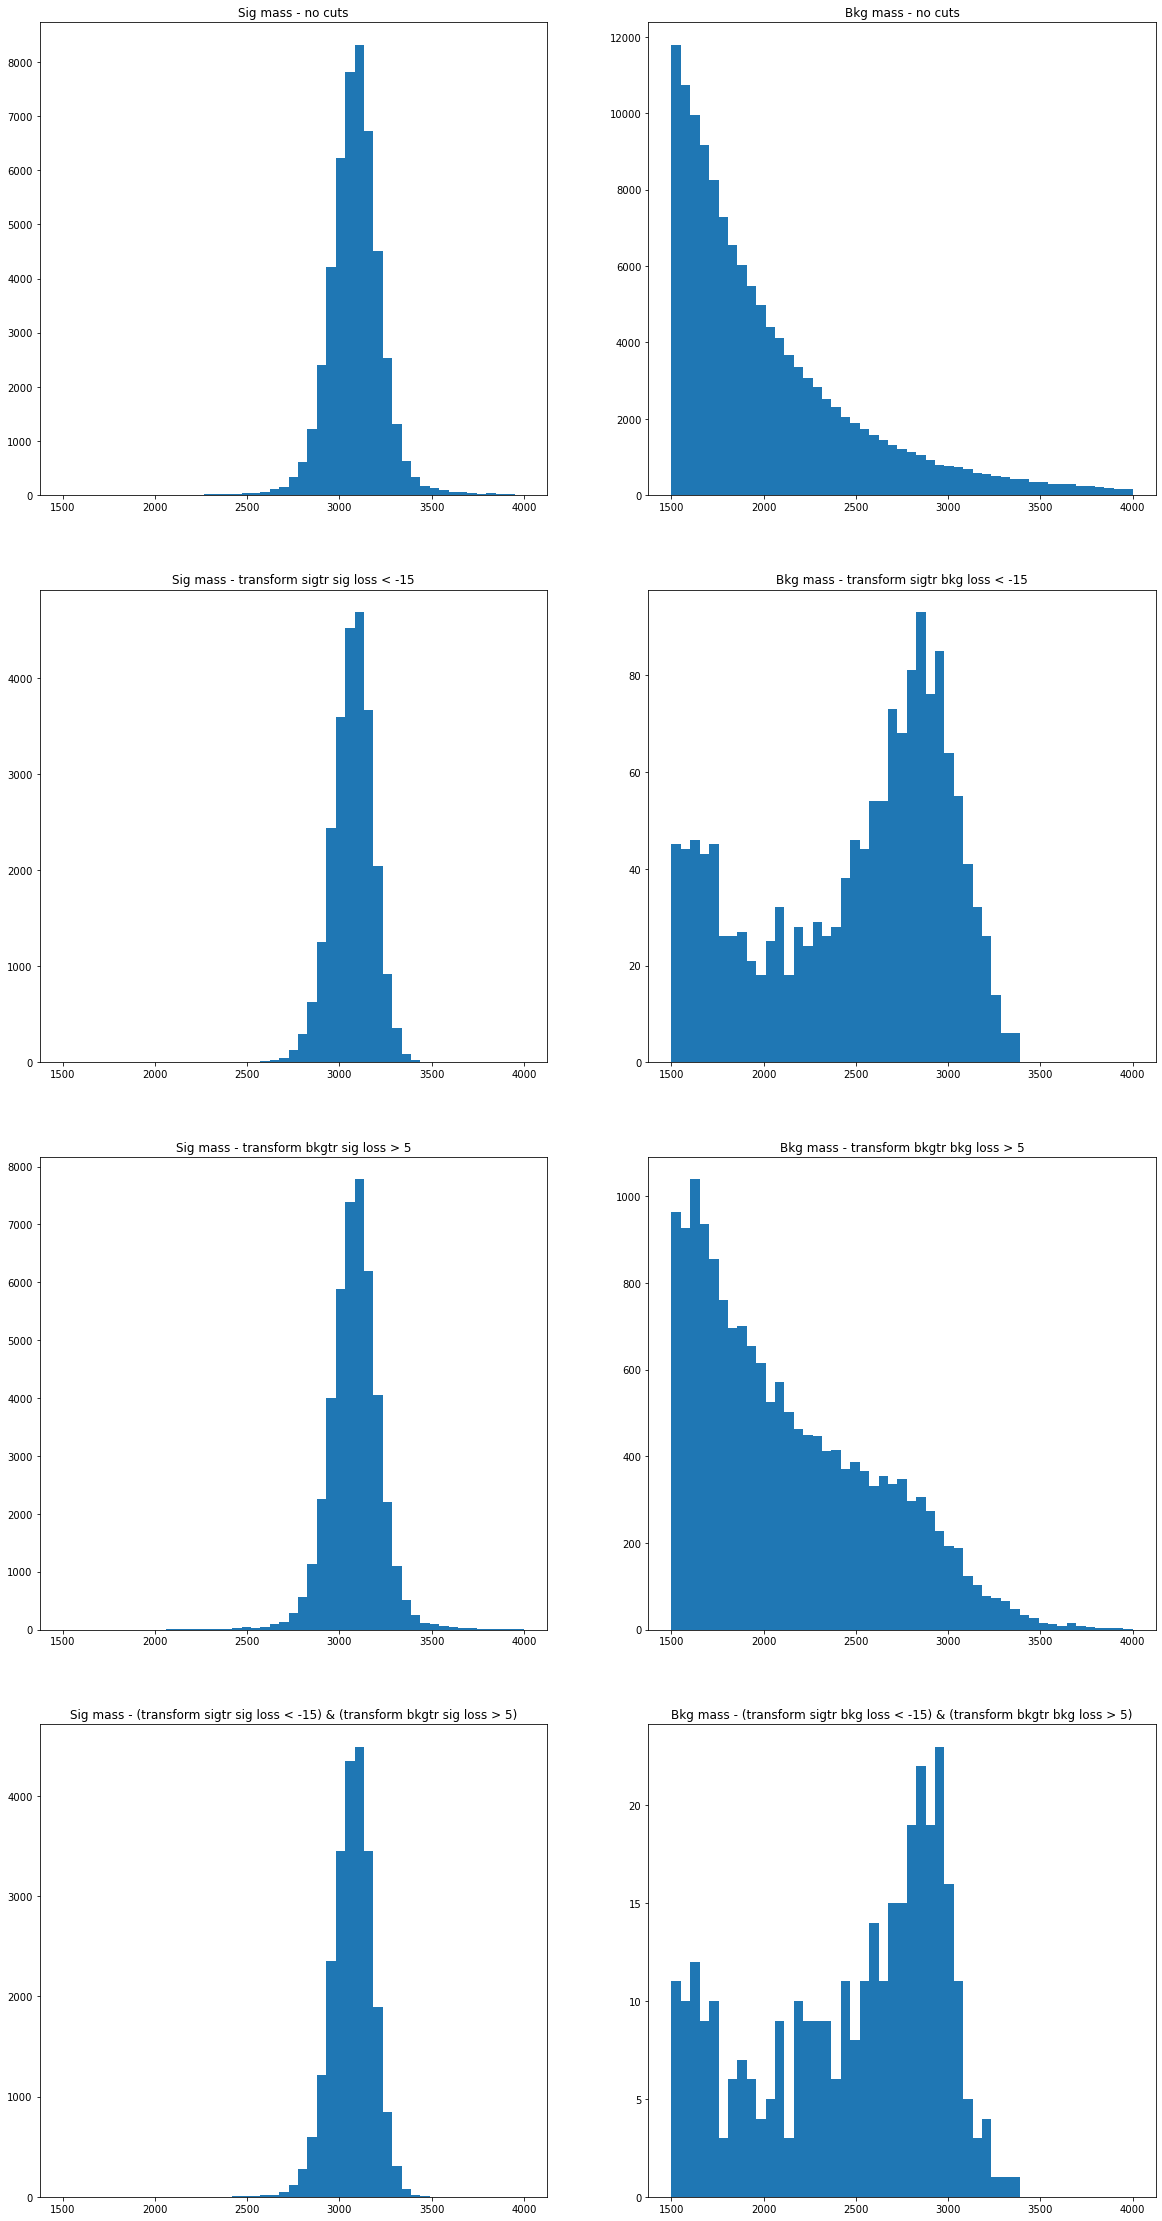

In [11]:
plt.figure(figsize=(20,40))

plt.subplot(421)
h1 = plt.hist(sig_mass,bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - no cuts")

plt.subplot(422)
h2 = plt.hist(bkg_mass,bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - no cuts")

plt.subplot(423)
h1 = plt.hist(sig_mass[(sig_transform[:,1]<-15)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - transform sigtr sig loss < -15")

plt.subplot(424)
h2 = plt.hist(bkg_mass[(bkg_transform[:,1]<-15)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - transform sigtr bkg loss < -15")

plt.subplot(425)
h1 = plt.hist(sig_mass[(sig_transform[:,2]>5)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - transform bkgtr sig loss > 5")

plt.subplot(426)
h2 = plt.hist(bkg_mass[(bkg_transform[:,2]>5)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - transform bkgtr bkg loss > 5")

plt.subplot(427)
h1 = plt.hist(sig_mass[(sig_transform[:,1]<-15)&(sig_transform[:,2]>5)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - (transform sigtr sig loss < -15) & (transform bkgtr sig loss > 5)")

plt.subplot(428)
h2 = plt.hist(bkg_mass[(bkg_transform[:,1]<-15)&(bkg_transform[:,2]>5)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - (transform sigtr bkg loss < -15) & (transform bkgtr bkg loss > 5)")

plt.savefig("plots/mass_decorrelation/XYY-training/mass-spectra-postTransform.png")